### Notebook to calculate available potential energy ($APE$) as defined by Hetland (2017) *JPO*.
> - APE is sourced from the lateral density gradients $APE_{\rho}$ and the sea surface height anomalies. Volume-integrated formulas shown below.
> - $APE_{\rho} = - \iiint \rho_0 \, b^\prime \, z \, dV$
> - $APE_{\eta} = - \iint \rho_0 \, g \, \eta^2 \, dydx$
> - Units are kg m$^2$ s$^{-2}$

In [2]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta
import time

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot as plt, patches

### Use the highest EKE ensembles as a test. These are shown in ```plt_surface_salt.ipynb```

In [3]:
paths = ['/d1/shared/shelfstrat_wind/tadv_ensembles/shelf_mpdata_uwind_zerop1_dt_30_across2x_50d_ensmb2_his.nc',
         '/d1/shared/shelfstrat_wind/tadv_ensembles/shelf_u3hc4_uwind_zerop1_dt_30_across2x_50d_ensmb3_his.nc',
         '/d1/shared/shelfstrat_wind/tadv_ensembles/shelf_hsimt_uwind_zerop1_dt_30_across2x_50d_ensmb1_his.nc',
        ]

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,721))
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)
    # print('iter complete')

In [4]:
ds = ds[0]
grid = grid[0]

### Buoyancy can be defined as $b = -g \frac{\rho_0-\rho}{\rho_0}$. First, we want to calculate density. The reference density inshore of the initially stratified region should be based on the mean density

In [64]:
def rho_linear_eos(ds):
    '''
Calculate density based on linear equation of state described in Hetland (2017)
    '''
    rho = 1027*((1+7.6*(10**-4*(ds.salt-35)))-(1.7*10**-4*(ds.temp-25)))
    return rho

rho0 = ds.rho0
rho = rho_linear_eos(ds)
g = 9.81
b = (-g*(rho0-rho))*(1/rho0)

In [65]:
bmean = b[:,:,:,1:-1].mean('xi_rho')
bmean = bmean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho':ds.z_rho.mean('xi_rho')})

Text(0.5, 0, 'Across-shore distance [m]')

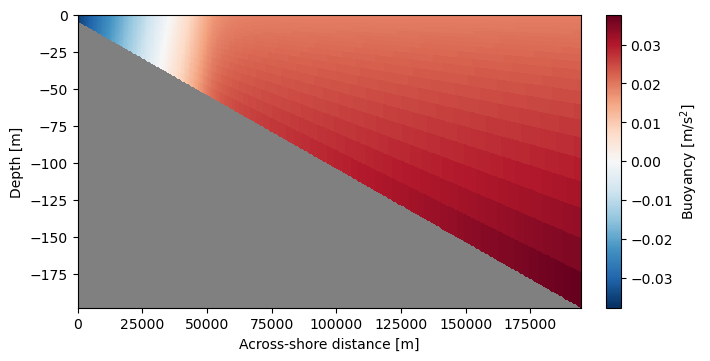

In [66]:
fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
bmean[0].plot(x = 'y_rho', y = 'z_rho', cbar_kwargs = {'label': 'Buoyancy [m/s$^2$]'})
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

### Quickly check paranthesis 

Text(0.5, 0, 'Across-shore distance [m]')

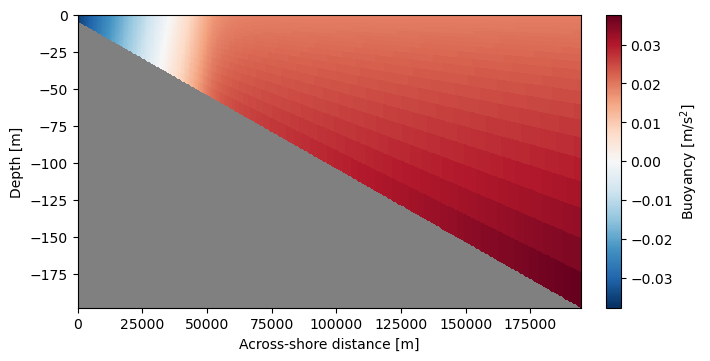

In [67]:
def rho_linear_eos1(ds):
    '''
Calculate density based on linear equation of state described in Hetland (2017)
    '''
    rho = 1027*(1+(7.6*(10**-4*(ds.salt-35)))-(1.7*10**-4*(ds.temp-25)))
    return rho

rho0 = ds.rho0
rho = rho_linear_eos1(ds)
g = 9.81
b = (-g*(rho0-rho))*(1/rho0)

bmean = b[:,:,:,1:-1].mean('xi_rho')
bmean = bmean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho':ds.z_rho.mean('xi_rho')})

fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
bmean[0].plot(x = 'y_rho', y = 'z_rho', cbar_kwargs = {'label': 'Buoyancy [m/s$^2$]'})
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

### What if we change $\rho_0$ to be based on the mean density of the entire water column?

In [9]:
rho0_alt = rho[0].mean().values
b_alt = (g*(rho0_alt-rho))*(1/rho0_alt)
bmean_alt = b_alt[:,:,:,1:-1].mean('xi_rho')
bmean_alt = bmean_alt.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho':ds.z_rho.mean('xi_rho')})

Text(0.5, 0, 'Across-shore distance [m]')

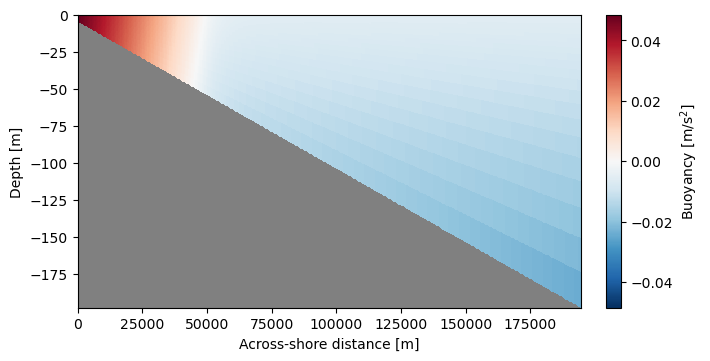

In [10]:
fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
bmean_alt[0].plot(x = 'y_rho', y = 'z_rho', cbar_kwargs = {'label': 'Buoyancy [m/s$^2$]'})
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

### Same trend emerges. Now try to calculate $APE_{\rho}$ with a reference buouyancy anomaly that ignores the initial salinity stratification. 
This means using the linear EOS without the salinity portion. Plot it to check initial structure 

Text(0.5, 0, 'Across-shore distance [m]')

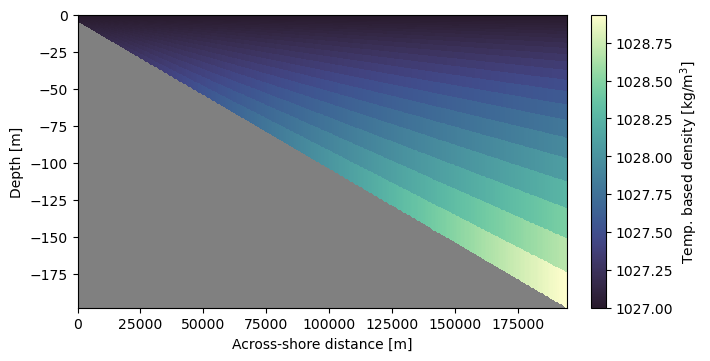

In [11]:
rho_temp = 1027*(1-(1.7*10**-4*(ds.temp-25)))
rhotmean = rho_temp[:,:,:,1:-1].mean('xi_rho')
rhotmean = rhotmean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho':ds.z_rho.mean('xi_rho')})

fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
rhotmean[0].plot(x = 'y_rho', y = 'z_rho', cmap = cmo.deep_r,
                cbar_kwargs = {'label': 'Temp. based density [kg/m$^{3}$]'})
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

Text(0.5, 0, 'Across-shore distance [m]')

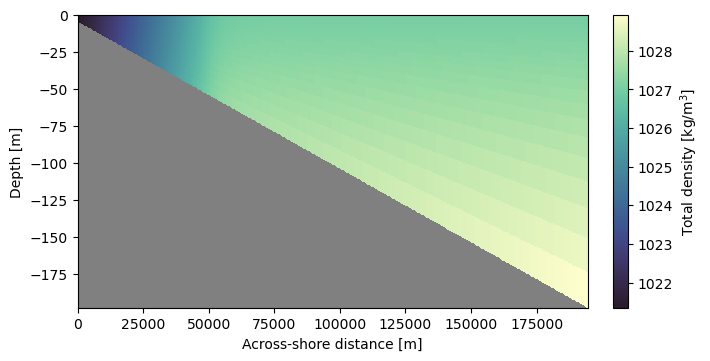

In [12]:
rhomean = rho[:,:,:,1:-1].mean('xi_rho')
rhomean = rhomean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho':ds.z_rho.mean('xi_rho')})

fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
rhomean[0].plot(x = 'y_rho', y = 'z_rho', cmap = cmo.deep_r,
                cbar_kwargs = {'label': 'Total density [kg/m$^{3}$]'})
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

### Now let's try computing the reference buoyancy

In [13]:
rho = rho_linear_eos(ds)
g = 9.81
rho0 = ds.rho0
b = (g*(rho0-rho))*(1/rho0)

rho_temp = (1027*(1-(1.7*10**-4*(ds.temp-25)))).isel(ocean_time = 0).values #Temperature based density @ first time
bref = (g*(rho_temp-(rho.isel(ocean_time = 0))))*(1/rho_temp) #Reference buoyancy 
bref
# bprime = b-bref

<xarray.DataArray (s_rho: 30, eta_rho: 389, xi_rho: 194)>
dask.array<mul, shape=(30, 389, 194), dtype=float32, chunksize=(30, 389, 194), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    x_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(389, 194), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(389, 194), meta=np.ndarray>
    ocean_time  object 0001-01-01 00:00:00
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 187 188 189 190 191 192 193
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 382 383 384 385 386 387 388
    z_rho       (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 389, 194), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 389, 194), meta=np.ndarray>
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   face
    field:      salinity, scalar, series

Text(0.5, 0, 'Across-shore distance [m]')

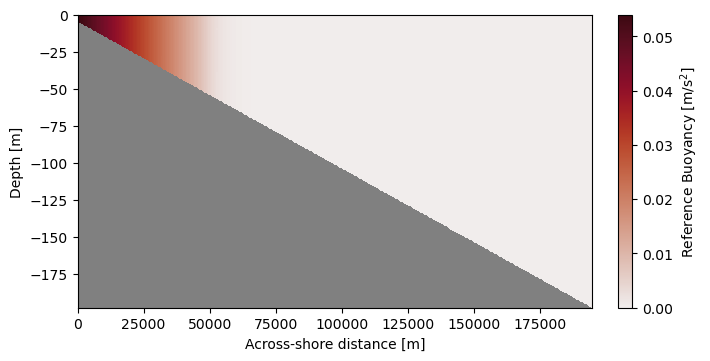

In [42]:
brefmean = bref.mean('xi_rho')
brefmean = brefmean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho0':ds.z_rho0.mean('xi_rho')})

fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
brefmean.plot(x = 'y_rho', y = 'z_rho0', cbar_kwargs = {'label': 'Reference Buoyancy [m/s$^2$]'}, cmap = cmo.amp)
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

In [37]:
bp = b-(bref.values)
bpmean = bp.mean('xi_rho')
bpmean = bpmean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho0':ds.z_rho0.mean('xi_rho')})

Text(0.5, 0, 'Across-shore distance [m]')

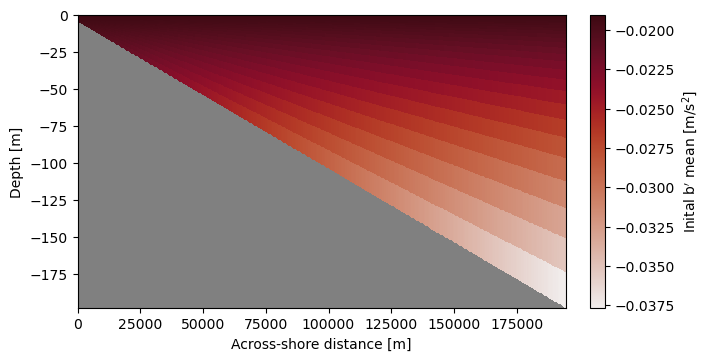

In [41]:
fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
bpmean[0].plot(x = 'y_rho', y = 'z_rho0', cbar_kwargs = {'label': 'Inital b$^\prime$ mean [m/s$^2$]'}, cmap = cmo.amp)
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

In [30]:
etaslice = slice(1,100)
xislice = slice(1,-1)

ape_r = -((1025*bp*ds.z_rho*ds.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['s_rho', 'eta_rho', 'xi_rho']))
ape_r.name = 'ape_rho'

In [43]:
ape_r[100:110].values

array([-5.82197873e+13, -5.81537500e+13, -5.80470747e+13, -5.79135510e+13,
       -5.77699605e+13, -5.76360138e+13, -5.75340983e+13, -5.74879134e+13,
       -5.75201899e+13, -5.76500548e+13])

### Still negative - what if we try recalculating with a difference density?

In [44]:
rho0_alt = rho[0].mean().values
b_alt = (g*(rho0_alt-rho))*(1/rho0_alt)

ape_r = -((rho0_alt*bp*ds.z_rho*ds.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['s_rho', 'eta_rho', 'xi_rho']))
ape_r.name = 'ape_rho'

In [45]:
ape_r[100:110].values

array([-5.83004802e+13, -5.82343514e+13, -5.81275282e+13, -5.79938195e+13,
       -5.78500299e+13, -5.77158976e+13, -5.76138408e+13, -5.75675919e+13,
       -5.75999131e+13, -5.77299580e+13])

### Is it gravity? 

In [46]:
rho = rho_linear_eos(ds)
g = 9.81
rho0 = ds.rho0
b = (-g*(rho0-rho))*(1/rho0)

rho_temp = (1027*(1-(1.7*10**-4*(ds.temp-25)))).isel(ocean_time = 0).values #Temperature based density @ first time
bref = (-g*(rho_temp-(rho.isel(ocean_time = 0))))*(1/rho_temp) #Reference buoyancy 
bref

bp = b-(bref.values)
bpmean = bp.mean('xi_rho')
bpmean = bpmean.assign_coords({'y_rho':ds.y_rho[:,0], 'z_rho0':ds.z_rho0.mean('xi_rho')})

Text(0.5, 0, 'Across-shore distance [m]')

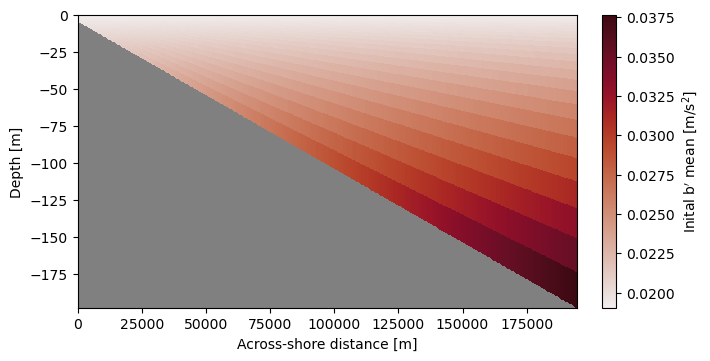

In [47]:
fig, ax = plt.subplots(1, figsize = (7,3.5), constrained_layout = True)
bpmean[0].plot(x = 'y_rho', y = 'z_rho0', cbar_kwargs = {'label': 'Inital b$^\prime$ mean [m/s$^2$]'}, cmap = cmo.amp)
ax.set_facecolor('gray')
plt.title('')
plt.ylabel('Depth [m]')
plt.xlabel('Across-shore distance [m]')

In [48]:
ape_r = -((1025*bp*ds.z_rho*ds.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['s_rho', 'eta_rho', 'xi_rho']))
ape_r.name = 'ape_rho'

In [49]:
ape_r[100:110].values

array([5.82197873e+13, 5.81537500e+13, 5.80470747e+13, 5.79135510e+13,
       5.77699605e+13, 5.76360138e+13, 5.75340983e+13, 5.74879134e+13,
       5.75201899e+13, 5.76500548e+13])

In [50]:
ape_r = -((1025*bp*ds.z_rho*ds.dV).isel(eta_rho = slice(1,193), xi_rho = xislice).sum(['s_rho', 'eta_rho', 'xi_rho']))
ape_r.name = 'ape_rho'
ape_r[100:110].values

array([4.04742786e+14, 4.04624311e+14, 4.04441034e+14, 4.04208135e+14,
       4.03948790e+14, 4.03694222e+14, 4.03481917e+14, 4.03352771e+14,
       4.03341692e+14, 4.03482079e+14])

In [58]:
#SSH anomalies 
ape_eta = -((1025*-g*ds.zeta**2*ds.dx*ds.dy).isel(eta_rho = etaslice, xi_rho = xislice).sum(['eta_rho', 'xi_rho']))
ape_eta.name = 'ape_eta'

In [63]:
(ape_eta[400:500].values.sum() / (ape_r[400:500].sum().values)) * 100

0.11272294088843164

### Now make this into a function and calculate for both schemes 

In [88]:
def rho_linear_eos(ds):
    '''
Calculate density based on linear equation of state described in Hetland (2017)
    '''
    rho = 1027*((1+7.6*(10**-4*(ds.salt-35)))-(1.7*10**-4*(ds.temp-25)))
    rho1 = 1027*(1+7.6*10**-4*(ds.salt-35)-(1.7*10**-4*(ds.temp-25)))
    return rho,rho1
rhotest,rhotest1 = rho_linear_eos(ds[0])

In [97]:
result_variable = (rhotest[0] == rhotest1[0]).all()

if(result_variable == True):
   print(" Yes!! The given arrays are equal. ")

else:
   print(" The given arrays are not equal. ")

 The given arrays are not equal. 


In [112]:
def rho_linear_eos(ds):
    '''
Calculate density based on linear equation of state described in Hetland (2017)
    '''
    rho = 1027*(1+7.6*10**-4*(ds.salt-35)-(1.7*10**-4*(ds.temp-25)))
    return rho

def calc_ape(ds, etaslice, xislice):
    '''
Calculate APE from lateral density gradients and SSH. See Eqs. B6 and B7
of Hetland (2017)
Inputs: 
-------
ds - xarray dataset
etaslice - across-shore slice (i.e. slice(1,100)) for init. stratified region. 
xislice - alongshore slice (i.e., slice(1,-1)) to remove periodic BCs

Outputs:
--------
ape: xarray dataarray with energy stored in lateral density gradients
    '''
    rho0 = 1025 #background density determined from input file
    rho = rho_linear_eos(ds)
    
    g = 9.81 
    b = (-g*(rho0-rho))*(1/rho0) 
    
    rho_temp = (1027*(1-(1.7*10**-4*(ds.temp[0]-25)))).values #Temperature based density @ first time
    rho_init = rho[0].values #Initial density 
    bref = (-g*(rho_temp-(rho_init)))*(1/rho_temp) #Reference buoyancy @ first time. Function of x,y,z

    bp = b-bref
    
    #Lateral density gradient APE
    ape_r = -((1025*bp*ds.z_rho*ds.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['s_rho', 'eta_rho', 'xi_rho'])).load()
    ape_r.name = 'ape_r'
    
    return ape_r

In [113]:
paths = ['/d1/shared/shelfstrat_wind/tadv_ensembles/shelf_mpdata_uwind_zerop1_dt_30_across2x_50d_ensmb3_his.nc',
         '/d1/shared/shelfstrat_wind/tadv_ensembles/shelf_u3hc4_uwind_zerop1_dt_30_across2x_50d_ensmb3_his.nc',
         '/d1/shared/shelfstrat_wind/tadv_ensembles/shelf_hsimt_uwind_zerop1_dt_30_across2x_50d_ensmb3_his.nc',
        ]

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,721))
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)
    # print('iter complete')

In [114]:
ape_r_mpdata = calc_ape(ds[0], etaslice, xislice)
ape_r_hsimt =  calc_ape(ds[2], etaslice, xislice)

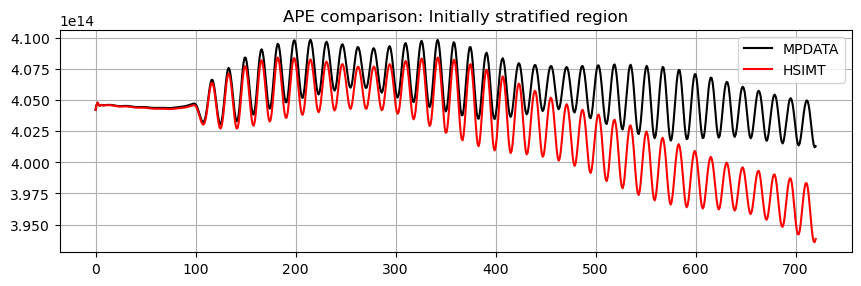

In [115]:
fig, ax = plt.subplots(1, figsize = (8.5,2.75), constrained_layout = True)

plt.plot(ape_r_mpdata, lw = 1.5, c = 'k', label = 'MPDATA')
plt.plot(ape_r_hsimt, lw = 1.5, c = 'r', label = 'HSIMT')

plt.title('APE comparison: Initially stratified region')
plt.grid()
plt.legend()

In [79]:
etaslice

slice(1, 100, None)

In [81]:
etaslice = slice(1,193)
ape_r_mpdata = calc_ape(ds[0], etaslice, xislice)
ape_r_hsimt =  calc_ape(ds[2], etaslice, xislice)

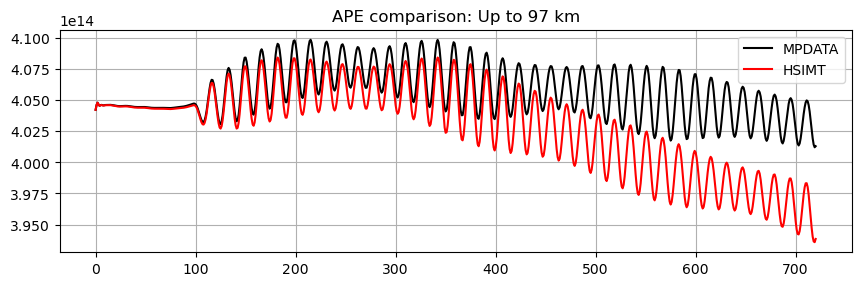

In [82]:
fig, ax = plt.subplots(1, figsize = (8.5,2.75), constrained_layout = True)

plt.plot(ape_r_mpdata, lw = 1.5, c = 'k', label = 'MPDATA')
plt.plot(ape_r_hsimt, lw = 1.5, c = 'r', label = 'HSIMT')

plt.title('APE comparison: Up to 97 km')
plt.grid()
plt.legend()

In [121]:
def calc_ape1(ds, etaslice, xislice):
    '''
Calculate APE from lateral density gradients and SSH. See Eqs. B6 and B7
of Hetland (2017)
Inputs: 
-------
ds - xarray dataset
etaslice - across-shore slice (i.e. slice(1,100)) for init. stratified region. 
xislice - alongshore slice (i.e., slice(1,-1)) to remove periodic BCs

Outputs:
--------
ape: xarray dataarray with energy stored in lateral density gradients
    '''
    rho0 = 1025 #background density determined from input file
    rho = rho_linear_eos(ds)
    
    g = 9.81 
    b = (g*(rho0-rho))*(1/rho0) 
    
    rho_temp = (1027*(1-(1.7*10**-4*(ds.temp[0]-25)))).values #Temperature based density @ first time
    rho_init = rho[0].values #Initial density 
    bref = (g*(1025-(rho_temp)))*(1/1025) #Reference buoyancy @ first time. Function of x,y,z

    bp = b-bref
    
    #Lateral density gradient APE
    ape_r = -((1025*bp*ds.z_rho*ds.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['s_rho', 'eta_rho', 'xi_rho'])).load()
    ape_r.name = 'ape_r'
    
    return ape_r

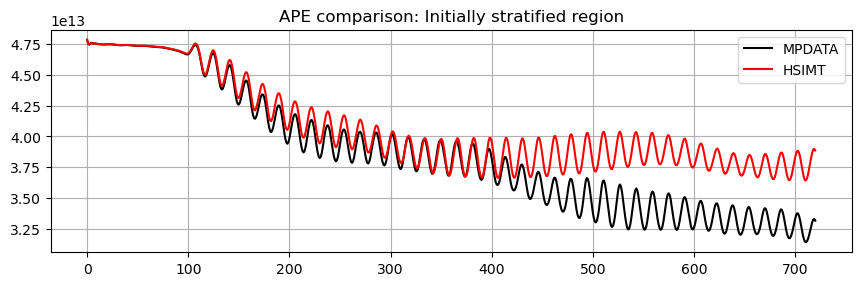

In [122]:
etaslice = slice(1,100)
ape_r_mpdata = calc_ape1(ds[0], etaslice, xislice)
ape_r_hsimt =  calc_ape1(ds[2], etaslice, xislice)

fig, ax = plt.subplots(1, figsize = (8.5,2.75), constrained_layout = True)

plt.plot(ape_r_mpdata, lw = 1.5, c = 'k', label = 'MPDATA')
plt.plot(ape_r_hsimt, lw = 1.5, c = 'r', label = 'HSIMT')

plt.title('APE comparison: Initially stratified region')
plt.grid()
plt.legend()

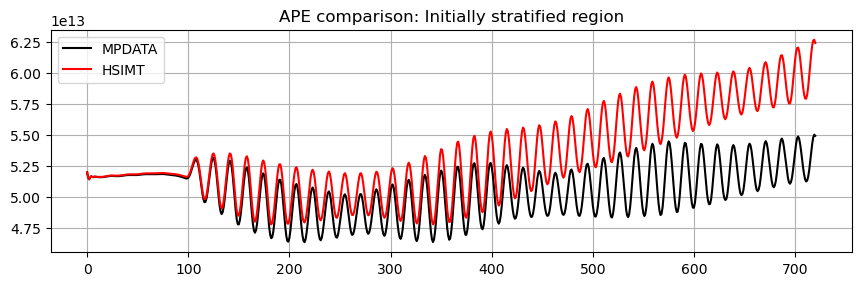

In [123]:
etaslice = slice(1,193)
ape_r_mpdata = calc_ape1(ds[0], etaslice, xislice)
ape_r_hsimt =  calc_ape1(ds[2], etaslice, xislice)

fig, ax = plt.subplots(1, figsize = (8.5,2.75), constrained_layout = True)

plt.plot(ape_r_mpdata, lw = 1.5, c = 'k', label = 'MPDATA')
plt.plot(ape_r_hsimt, lw = 1.5, c = 'r', label = 'HSIMT')

plt.title('APE comparison: Initially stratified region')
plt.grid()
plt.legend()